In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.backend import clear_session
from tensorflow.keras import Model

In [2]:
# load data
np_data = np.load("data/dataRS.npy")

noise_output = np_data[:,-1].reshape(len(np_data),1)
input = np_data[:,:-1]

# split data
test_split = 0.33
x_train, x_test, y_train, y_test = train_test_split(input, noise_output, test_size=test_split)

### Enter your tag as unique id for saving

In [3]:
tag = str("autoencoder-18032023")

In [4]:
#Create a autoencode like in https://blog.keras.io/building-autoencoders-in-keras.html
clear_session()
encoding_dim = 3
inputLayer = Input(shape=(x_train.shape[1],))
encoded = Dense(encoding_dim, activation="relu")(inputLayer) # activity_regularizer=regularizers.l1(10e-5)
decoded = Dense(x_train.shape[1], activation="relu")(encoded)
autoencoder = Model(inputLayer, decoded)
autoencoder.summary()

plot_model(autoencoder, to_file="archive/model"+tag+".png",show_shapes=True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5)]               0         
                                                                 
 dense (Dense)               (None, 3)                 18        
                                                                 
 dense_1 (Dense)             (None, 5)                 20        
                                                                 
Total params: 38
Trainable params: 38
Non-trainable params: 0
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [5]:
# Encoder
encoder = Model(inputLayer, encoded)
# Decoder
encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))


In [6]:
#Training
#['mean_squared_error', 'mean_absolute_error','mean_squared_logarithmic_error', 'mean_absolute_percentage_error']

def scheduler(epoch, lr):
    if epoch < 3:
        return lr
    else:
        return lr* tf.math.exp(-2.3)
LearningRateScheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="auto", min_delta=0.0001, patience=20)

optRMS = tf.keras.optimizers.RMSprop(learning_rate=0.05)

autoencoder.compile(optimizer = 'rmsprop', loss='mean_squared_error', metrics=['mean_absolute_error'])

autoencoder_history = autoencoder.fit(x_train, x_train, epochs=100, batch_size=25, validation_split=0.25, callbacks=[EarlyStopping])

Epoch 1/100
31/31 [==============================] - 0s 5ms/step - loss: 0.1571 - mean_absolute_error: 0.2711 - val_loss: 0.1408 - val_mean_absolute_error: 0.2556
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 0.1311 - mean_absolute_error: 0.2494 - val_loss: 0.1119 - val_mean_absolute_error: 0.2302
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 0.1062 - mean_absolute_error: 0.2280 - val_loss: 0.0866 - val_mean_absolute_error: 0.2085
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 0.0836 - mean_absolute_error: 0.2110 - val_loss: 0.0682 - val_mean_absolute_error: 0.1939
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 0.0684 - mean_absolute_error: 0.1995 - val_loss: 0.0573 - val_mean_absolute_error: 0.1861
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 0.0596 - mean_absolute_error: 0.1916 - val_loss: 0.0511 - val_mean_absolute_error: 0.1788
Epoch 7/100
31/31 [===

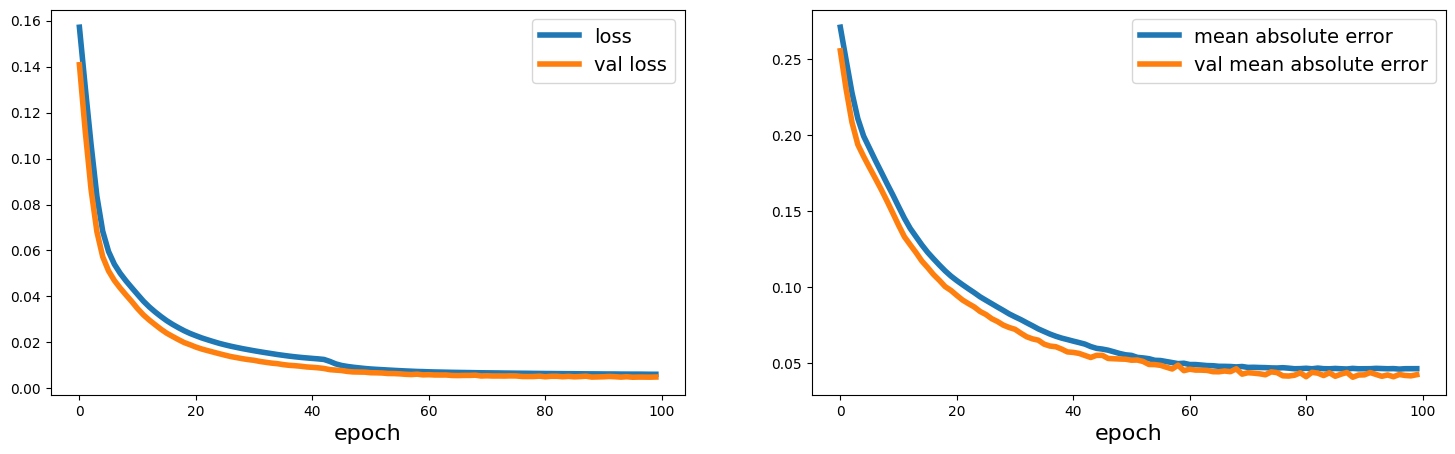

In [11]:
def plot_metrics(history):
    n = len(history.history.keys())//2
    fig,axs = plt.subplots(1,n, figsize=(18,5))

    for i,[key,val] in enumerate(history.history.items()):
        axs[i%n].plot(history.history[key], lw=4, label=key.replace("_", " "))
    
    for ax in axs:
        #ax.set_yscale("log")
        ax.set_xlabel("epoch", fontsize=16)
        ax.legend(fontsize=14)
plot_metrics(autoencoder_history)
plt.savefig("archive/history-"+tag+".png")

In [8]:
evaluation = autoencoder.evaluate(x_test[:-1], x_test[:-1])
encoded_test = encoder.predict(x_test)
decoded_test = decoder.predict(encoded_test)
print(f'Data: {x_test[0,:]} to be: {encoded_test[0,:]} and rebuilded it to: {decoded_test[0,:]}')

16/16 [==============================] - 0s 668us/step
Data: [0.07070707 0.32882883 0.72727273 1.         0.1730669 ] to be: [1.6906788 1.2280583 0.6614942] and rebuilded it to: [0.14243846 0.29944175 0.6915221  0.9997922  0.26000437]


In [9]:
encoder.save("archive/encoderModel-"+tag+".h5")
autoencoder.save("archive/completeModel-"+tag+".h5")
config = encoder.get_config()
np.save("archive/encoderConfig-"+tag+".npy", config)
config = autoencoder.get_config()
np.save("archive/completeConfig-"+tag+".npy", config)

In [10]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5)]               0         
                                                                 
 dense (Dense)               (None, 3)                 18        
                                                                 
 dense_1 (Dense)             (None, 5)                 20        
                                                                 
Total params: 38
Trainable params: 38
Non-trainable params: 0
_________________________________________________________________
